<a href="https://colab.research.google.com/github/agdylan/research_code/blob/main/Experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --no-dependencies icon_registration==1.1.2

In [ ]:
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt

In [ ]:
# Retrieves the first 5 samples of the training split of the MNIST dataset, handwritten digits
ds, _ = icon_registration.data.get_dataset_mnist(split="train", number=5)

# Get an iterator the the dataset and retrive the first batch
sample_batch = next(iter(ds))[0]

# Create a grid of the first 12 images with 4 images per row and display it
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])


In [ ]:
# Get the first two images from the dataset
image_A, image_B = next(iter(ds))[0][:2]  # Select the first two images from the batch

# Save images A and B as tensors
torch.save(image_A, 'image_A.pt')
torch.save(image_B, 'image_B.pt')



#import torch

# Load image A tensor
#image_A = torch.load('image_A.pt')

# Load image B tensor
#image_B = torch.load('image_B.pt')

In [ ]:
inner_net = icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))

for _ in range(3):
     inner_net = icon.TwoStepRegistration(
         icon.DownsampleRegistration(inner_net, dimension=2),
         icon.FunctionFromVectorField(networks.tallUNet2(dimension=2))
     )


In [ ]:
# Define regularizers
regularizers = [
    ('GradICON', icon.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=.5)),
    ('Diffusion', icon.GradientICON(inner_net, icon.Diffusion(alpha=0.01), lmbda=.5)),
    ('BendingEnergy', icon.GradientICON(inner_net, icon.BendingEnergy(), lmbda=.5))
]

# Initialize dictionary to store vector fields for each regularizer
vector_fields = {reg_name: [] for reg_name, _ in regularizers}

# Train 10 registration networks for each regularizer
for reg_name, regularizer in regularizers:
    for i in range(10):
        # Initialize network
        net = regularizer

        # Initialize identity map for the provided sample batch
        net.assign_identity_map(sample_batch.shape)

        # Put network in training mode
        net.train()

        # Move the network parameters to the specified device (GPU or CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net.to(device)

        optim = torch.optim.Adam(net.parameters(), lr=0.001)

        # Train the network using provided dataset for 5 epochs
        curves = icon.train_datasets(net, optim, ds, ds, epochs=5)

        # Pass both images through the network
        image_A = next(iter(ds))[0].to(device)
        image_B = next(iter(ds))[0].to(device)
        net(image_A, image_B)

        # Store vector field tensor
        vector_fields[reg_name].append(net.phi_AB_vectorfield)

# Compute statistical tests for each regularizer (you can replace this with your desired statistical tests)
for reg_name, vf_list in vector_fields.items():
    print(f"Regularizer: {reg_name}")
    # Example: Compute mean and standard deviation of the vector fields
    mean_vector_field = torch.mean(torch.stack(vf_list), dim=0)
    std_vector_field = torch.std(torch.stack(vf_list), dim=0)
    print(f"Mean Vector Field:\n{mean_vector_field}")
    print(f"Standard Deviation Vector Field:\n{std_vector_field}")

# Plot contour lines of the vector field for each iteration
plt.figure(figsize=(12, 8))
for i, (reg_name, vf_list) in enumerate(vector_fields.items()):
    for j, vf in enumerate(vf_list):
        plt.subplot(len(regularizers), len(vf_list), i * len(vf_list) + j + 1)
        plt.contour(torchvision.utils.make_grid(vf[:6], nrow=3)[0].cpu().detach())
        plt.title(f"{reg_name} - Iteration {j+1}")

plt.tight_layout()
plt.show()

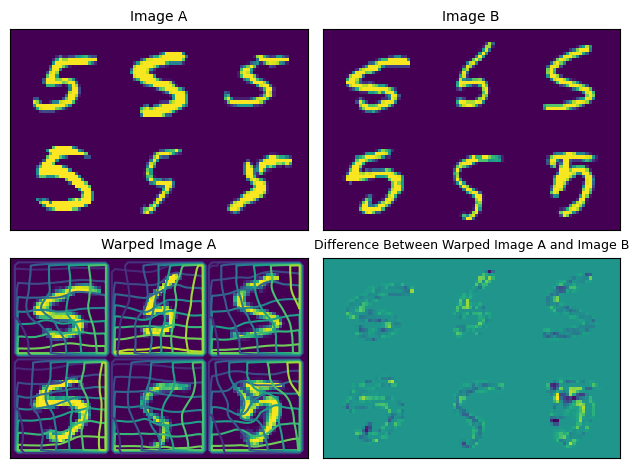

In [ ]:

# Defines function to display tensors as images
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:6], nrow=3)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])

# retrieves first image from the dataset and moves it to specified device
image_A = next(iter(ds))[0].to(device)
# retrieves second image from teh dataset and moves it to specified device
image_B = next(iter(ds))[0].to(device)

# Passes both images through the network
net(image_A, image_B)

# Defines subplots in a 2x2 grid for displaying images and results
plt.subplot(2, 2, 1) # First subplot
show(image_A) # Display image A
plt.title("Image A", fontsize=10)
plt.subplot(2, 2, 2) # Second subplot
show(image_B) # Display image B
plt.title("Image B", fontsize=10)
plt.subplot(2, 2, 3) # Third Subplot
show(net.warped_image_A) # Display warped image A(output from the network). Goal is to align it with image B
plt.title("Warped Image A", fontsize=10)

# Overlays contours of the vector field on the warped image A.
# Contour of Vector Field on warped image A - allows us to visualize how the transformation varies across different regions of the image.
# Regions with dense contour lines indicates areas where transformation is significant
# Sparse contour lines suggest areas with minimal transformation
# Again contour lines allows us to see how the transformation varies spatially across the image
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[0].cpu().detach()) # Draws vertical grid lines
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:6], nrow=3)[1].cpu().detach()) # Draws horizontal grid lines

plt.subplot(2, 2, 4) # Fourth Subplot

# Assessment of Alignment: Display the difference between warped image A and image B
show(net.warped_image_A - image_B)

# Add a title to the subplot
plt.title("Difference Between Warped Image A and Image B", fontsize=9)

# Adjust the layout of subplots to prevent overlap
plt.tight_layout()

**Goal of Experiment**
* Aim to investigate whether the contour lines of the vector field, derived from the transformed image, exhibit variability acrossing multiple training iterations of the network. We will conduct these experiments with each of GradIcon, Bending Energy, and Diffusion Regularizers
* Will provide insights into the stability and reproducibility of the regularization techniques in shaping the transformations applied to the image during the training process


*   Curious of about the statistical properites of the vectors and the covariance matrix
*  Expections is the vectors are similar to each other for diffusion and vary more with GradICON
*   Final product is targeting writeup describing the question and looking.






**Structure of Experiments **


*   Pick two batches of images and save those on disk with torch.save
*   Train 30 networks with a for loop


*   Call each of those networks on batches of images so the inputs are the same but networks differ
*  Stack vector fields into a new tensor with shape 30,128,28,28


*







